# 条件波动率和波动率溢出的关系

In [107]:
import pandas as pd
volatilities = pd.read_csv('datasets/processed_data/conditional_vol.csv', index_col=0)
#volatilities = volatilities.iloc[-500:, :500]

### 数据平稳性检验和差分处理

In [67]:
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
adf_no_list = []
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # 返回p值


for col in tqdm(volatilities.columns):
    p_value = check_stationarity(volatilities[col])
    if p_value > 0.05:            # 如果p值大于0.05，进行差分
        adf_no_list.append(col)
print(len(adf_no_list))

  0%|          | 0/500 [00:00<?, ?it/s]

85


In [68]:
print(len(adf_no_list))

85


### 波动率溢出指数

使用Diebold和Yilmaz的方法计算波动率溢出指数。该方法通过VAR（向量自回归）模型计算不同时间序列之间的波动率传递和溢出效应。


In [69]:
volatilities = volatilities.drop(adf_no_list, axis=1)
volatilities.shape

(500, 415)

In [70]:
# 查找全是常数的列
constant_columns = [col for col in volatilities.columns if volatilities[col].nunique() < 100]
constant_columns

[]

In [71]:
# 删除全是常数的列
volatilities = volatilities.drop(columns=constant_columns)

In [72]:
from statsmodels.tsa.api import VAR
model = VAR(volatilities)
results = model.fit(maxlags=5)
H=5

/Users/hans/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [73]:
import numpy as np
from tqdm import tqdm
# 获取模型残差的协方差矩阵及其逆矩阵
sigma_u = results.sigma_u
sigma_u_inv = np.linalg.inv(sigma_u)

# 计算 GFEVD
def compute_gfevd(H, A, sigma_u, sigma_u_inv):
    n_vars = A.shape[1]
    gfevd = np.zeros((n_vars, n_vars))
    e = np.eye(n_vars)
    
    for i in tqdm(range(n_vars)):
        for j in range(n_vars):
            num = sigma_u_inv[j, j] * np.sum([(e[i].T @ A[h] @ sigma_u @ e[j]) ** 2 for h in range(H)]) 
            den = np.sum([(e[i].T @ A[h] @ sigma_u @ A[h].T @ e[i]) for h in range(H)])
            gfevd[i, j] = num / den
    return gfevd


In [74]:
MA_A = results.ma_rep(maxn=5)

In [75]:
# 计算 GFEVD
gfevd = compute_gfevd(H, MA_A, sigma_u, sigma_u_inv)

gfevd = pd.DataFrame(gfevd[:,:], index=volatilities.columns,
             columns=volatilities.columns)

gfevd

100%|██████████| 415/415 [08:42<00:00,  1.26s/it]


,000001,000005,000006,000007,000008,000009,000010,000011,000014,000016,...,002058,002059,002060,002061,002062,002063,002064,002065,002066,002067
000001,167.251789,22.980037,38.298827,64.147626,61.067967,22.202875,23.713066,9.899132,64.541872,88.263447,...,56.388124,17.208079,61.023476,15.814884,8.365614,118.377067,150.465783,19.188454,59.144506,7.538930
000005,42.440735,24.112947,10.994963,152.154941,69.807333,23.093950,38.430028,17.738171,22.989449,84.379210,...,40.546625,37.180790,25.863991,24.362021,8.411708,87.954315,56.297001,26.560553,47.884311,13.972484
000006,82.180004,13.754036,38.633512,127.061452,103.248059,27.355648,12.106851,9.239554,91.592732,110.843308,...,56.913853,23.187407,33.952075,9.695847,12.982752,140.246312,202.685850,9.725668,89.874677,12.665249
000007,20.772771,5.171478,5.161918,300.290186,174.860541,27.340422,37.152245,16.776462,115.064671,131.239176,...,52.921704,22.103730,12.436884,19.668619,7.670852,133.556555,244.756376,29.139828,138.754540,18.144746
000008,20.690816,2.644553,8.578859,154.021270,217.669812,54.511892,10.100722,13.893499,166.022932,57.417994,...,36.057052,31.303795,15.165330,9.421494,16.555828,199.676208,307.066468,9.505597,161.224241,14.473927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
002063,29.758882,9.105117,2.341334,71.485371,181.163164,17.993221,26.799976,29.930586,137.769021,68.849805,...,66.001368,78.323580,28.759368,4.088532,26.299974,534.199473,217.930891,4.874400,33.799159,22.183837
002064,43.985231,3.903790,10.570592,146.529566,199.754700,96.520656,4.032747,5.926896,249.231294,82.167783,...,46.726827,1.636337,30.998525,2.380820,0.913659,159.542513,557.986840,1.920877,259.440733,9.843395
002065,54.779761,10.615517,13.128263,187.576373,105.601299,38.908130,46.400033,19.160049,103.870313,126.914035,...,55.548194,10.354784,34.082374,15.568133,2.639433,94.701346,240.553043,34.549680,134.659894,12.146370
002066,15.600515,0.803280,9.255997,123.952661,108.305135,140.833118,10.646427,34.270417,144.045715,35.339080,...,11.494200,22.445113,8.803656,2.310730,4.797184,30.440383,337.076389,8.021640,353.190539,2.769061


### 归一化

In [81]:
def scale_one(df):
    # j 归一化
    s1 = df.values
    s2 = df.values.sum(axis=1)
    s3 = (s1.T/s2).T
    return pd.DataFrame(s3, index=df.index, columns=df.index)

In [82]:
gfevd_scaled = scale_one(gfevd)

In [92]:
import pandas as pd
path='datasets/华证2009-2023年（含细分项+季度)）/华证esg评级2009-2023（细分项）/华证esg评级含细分项（年度）2009-2023.xlsx'
ESG_df = pd.read_excel(path, dtype={'股票代码':str})
ESG_df['股票代码'] = ESG_df['股票代码'].str.zfill(6)
ESG_df.head(1)

,股票代码,年份,综合评级,综合得分,E评级,E得分,S评级,S得分,G评级,G得分,...,重污染分组2,重污染分组3,所属省份代码,所属省份,所属城市代码,所属城市,是否属于西部,是否属于东部,是否属于中部,产权性质
0,000001,2009,BBB,82.38,CCC,69.87,BB,77.46,AA,91.77,...,0.0,0.0,440000.0,广东省,440300.0,深圳市,0.0,1.0,0.0,0.0


In [97]:
df = pd.DataFrame(gfevd_scaled.mean(), columns=['gfevd'])
df['conditional_vol'] = volatilities.mean()
ESG = ESG_df[['股票代码', '综合得分']].groupby('股票代码').mean()
df['ESG_Score'] = ESG
df

,gfevd,conditional_vol,ESG_Score
000001,0.001381,1.671599,83.117333
000005,0.000293,2.176908,65.218667
000006,0.000368,2.618998,80.014000
000007,0.003808,2.313067,67.800667
000008,0.003585,1.991441,70.848000
...,...,...,...
002063,0.005945,2.535804,78.850000
002064,0.007072,1.723903,73.255333
002065,0.000469,2.154844,76.232000
002066,0.004136,2.664736,69.768667


<Axes: >

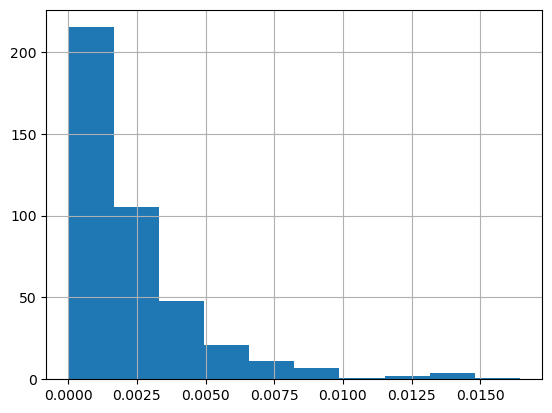

In [105]:
df['gfevd'].hist()

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

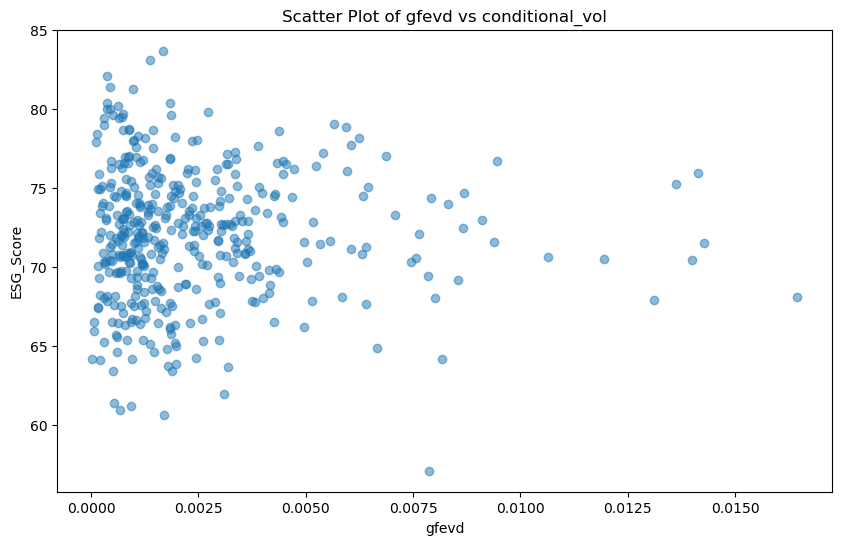

In [99]:
# df.plot(kind='scatter', x='Volatility', y='ESG_Score')
plt.figure(figsize=(10, 6))
plt.scatter(df['gfevd'], df['ESG_Score'], alpha=0.5)
plt.title('Scatter Plot of gfevd vs conditional_vol')
plt.xlabel('gfevd')
plt.ylabel('ESG_Score')
plt.show()

In [100]:
# 计算皮尔逊相关系数
corr, p_value = pearsonr(df['gfevd'], df['ESG_Score'])
print(f"Pearson correlation coefficient: {corr:.4f}, P-value: {p_value:.4f}")

Pearson correlation coefficient: -0.0125, P-value: 0.7990


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

X = df['gfevd']
y = df['ESG_Score']
X = sm.add_constant(X)  # 添加常数项
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ESG_Score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.06490
Date:                Tue, 16 Jul 2024   Prob (F-statistic):              0.799
Time:                        18:09:58   Log-Likelihood:                -1180.1
No. Observations:                 415   AIC:                             2364.
Df Residuals:                     413   BIC:                             2372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.0345      0.286    251.841      0.0